In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight
import os
import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def loadLimitFiles(mass,fpath):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        # f= "../limit/combine/HNL_datacards/muon_v1/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root"
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        xsec = f_xsec(mass)(float(ct))
#         print(ct,xsec)    
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
        card = os.path.dirname(f)+"/%s_CSC.txt"%signalName
        norm = float(open(card,'r').readline().split()[-1])
        limit = loadLimits(f)
#        print(len(limit))
        if len(limit) !=6:
            print("Problem loading limit for ",signalName)
        else:
            arr.append(loadLimits(f)*xsec/norm)
            ctau.append(float(ct))        
#         arr.append(loadLimits(f)*xsec)
#         ctau.append(float(ct))
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True, legend=True):

    # expected CLs
    if legend:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$")
    else:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label='_nolegend_')        
        
    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")

    
    return ax
from HNLprocessor.util import f_xsec
from HNLprocessor.util import f_v2

## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect2(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return np.log(funcs[i](x))-np.log(xsec(x)) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
#         rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
        if f=="linear":
            rbfi = interp1d(x, y,fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            

        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

def plotOneMass(arr,ctau,mass,label,showBand=True,ax=None,addTheory=True):
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)

    plt.style.use(hep.style.CMS) 

    if ax ==None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax = plotlimit(ax,arr_i,ctau_i,showBand)
    if addTheory:
        ax.plot(ctau_i,f_xsec(mass)(ctau_i),label="Theory")

    ax.set_xlabel("ctau[mm]")
    ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend([label,"Theory"])
    return ax,funcs

# Load limits into arrays

In [39]:
arr_4GeV_CSC,ct_4GeV_CSC = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_CSC.AsymptoticLimits.mH120.root")
arr_4GeV_DT,ct_4GeV_DT = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_DT.AsymptoticLimits.mH120.root")

In [7]:
arr4p5GeV,ctau4p5GeV = loadLimitFiles(4.5,"../limit/higgsCombine_HNL_muonType_mHNL4p5_pl*_comb.AsymptoticLimits.mH120.root")
arr4p6GeV,ctau4p6GeV = loadLimitFiles(4.6,"../limit/higgsCombine_HNL_muonType_mHNL4p6_pl*_comb.AsymptoticLimits.mH120.root")
arr4p7GeV,ctau4p7GeV = loadLimitFiles(4.7,"../limit/higgsCombine_HNL_muonType_mHNL4p7_pl*_comb.AsymptoticLimits.mH120.root")
arr5GeV,ctau5GeV = loadLimitFiles(5,"../limit/higgsCombine_HNL_muonType_mHNL5p0_pl*_comb.AsymptoticLimits.mH120.root")
arr4GeV,ctau4GeV = loadLimitFiles(4,"../limit/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root")
arr2GeV,ctau2GeV = loadLimitFiles(2,"../limit/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")

# Example of comparing two different limits

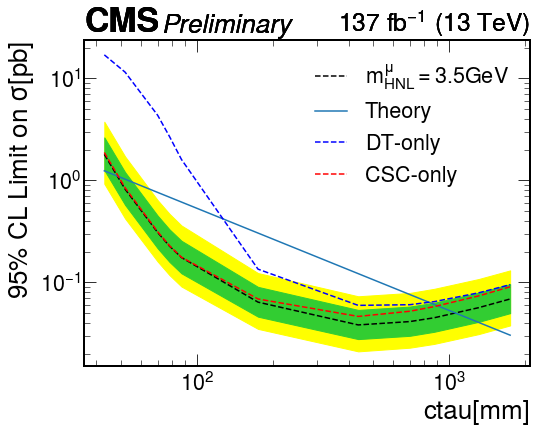

In [6]:
arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")
arrDT,ctauDT = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_DT.AsymptoticLimits.mH120.root")
arrCSC,ctauCSC = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_CSC.AsymptoticLimits.mH120.root")

arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
arrDT_i, ctauDT_i,funcs = interpolate1D(arrDT, ctauDT,-1)
arrCSC_i, ctauCSC_i,funcs = interpolate1D(arrCSC, ctauCSC,-1)

ax, func_3 = plotOneMass(arr,ctau,3,r"$m_{HNL}^\mu=3.5GeV$",True)
plt.style.use(hep.style.CMS) 

ax = plotlimit(ax,arrDT_i,ctauDT_i,False)
ax = plotlimit(ax,arrCSC_i,ctauCSC_i,False)

# ax.plot(ctau,f_xsec(3)(ctau),label="Theory")
ax.get_lines()[2].set_color('b') 
ax.get_lines()[3].set_color('r')

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend()
ax.legend([r"$m_{HNL}^\mu=3.5GeV$","Theory","DT-only","CSC-only"])

# Limit v.s. cta

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[715.27827223 556.46879804 261.79298281 200.         200.        ]


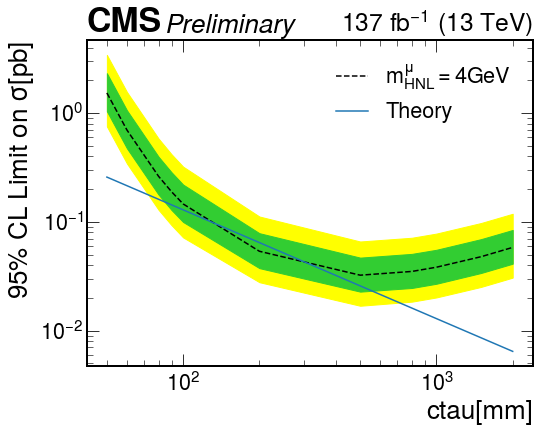

In [42]:
arr4GeV,ctau4GeV = loadLimitFiles(4,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_4 = plotOneMass(arr4GeV,ctau4GeV,4,r"$m_{HNL}^\mu=4GeV$",False)

ct_xing_4 = intersect(func_4,f_xsec(4),200)
print(ct_xing_4)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

[1024.16616871  834.19535117  635.42327203  459.04878801  200.85281777]
[ 51.1269451   61.15702044  68.68380016  83.40626147 168.52607102]


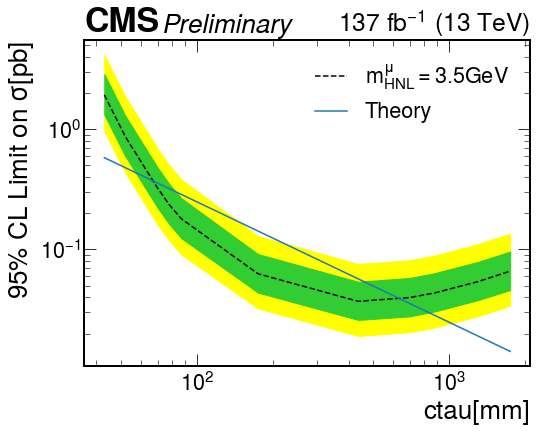

In [17]:
# arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_3p5 = plotOneMass(arr,ctau,3.5,r"$m_{HNL}^\mu=3.5GeV$")
ct_xing_3p5 = intersect(func_3p5,f_xsec(3.5),[1000,800,700,200,200])
print(ct_xing_3p5)
ct_xing_3p5_up = intersect(func_3p5,f_xsec(3.5),[50,50,50,50,50])
print(ct_xing_3p5_up)
# plt.savefig("./figures/result/AsymLimit_muon_3p5GeV.pdf")

In [40]:
intersect2(func_3,f_xsec(3),[1000,800,700,200,200])

array([1343.7864304 , 1156.90516895,  960.53098004,  782.97961664,
        637.2040991 ])

[1541.30649649 1285.07642279 1033.21233679  809.40691136  637.85423177]
[  28.49685253   17.15898498 1033.21233679  809.4069114    56.77239607]


/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


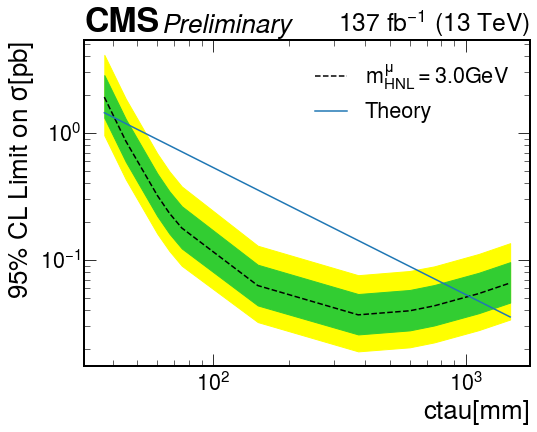

In [18]:
# arr,ctau = loadLimitFiles(3,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL3p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(3,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL3p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_3 = plotOneMass(arr,ctau,3,r"$m_{HNL}^\mu=3.0GeV$")
ct_xing_3 = intersect(func_3,f_xsec(3),[1000,800,700,200,200])
print(ct_xing_3)
ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
print(ct_xing_3_up)
plt.savefig("./figures/result/AsymLimit_muon_3GeV.pdf")

array([ True,  True,  True, False,  True,  True,  True])

[4077.04743134 3471.86253834 2867.34148957 2344.00888596 1948.24162329]


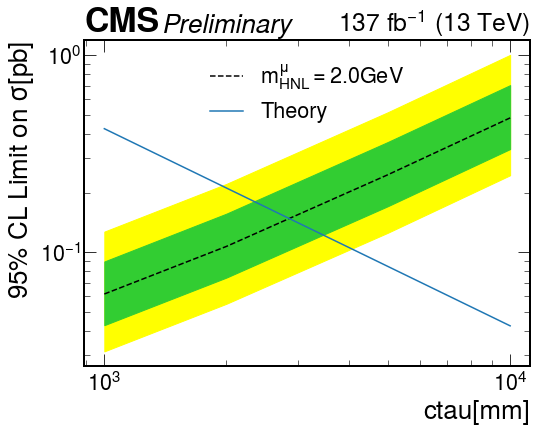

In [19]:
# arr,ctau = loadLimitFiles(2,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(2,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")
arr = arr[ctau>=1e3]
ctau = ctau[ctau>=1e3]
ax, func_2 = plotOneMass(arr,ctau,2,r"$m_{HNL}^\mu=2.0GeV$")
ct_xing_2 = intersect(func_2,f_xsec(2),2000)
print(ct_xing_2)
# ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
# print(ct_xing_3_up)
# plt.savefig("./figures/result/AsymLimit_muon_2GeV.pdf")

Problem loading limit for  HNL_muonType_mHNL1p0_pl100
[11978.69117078 10288.72379235  8856.15796951  7668.43800498
  6774.37900561]


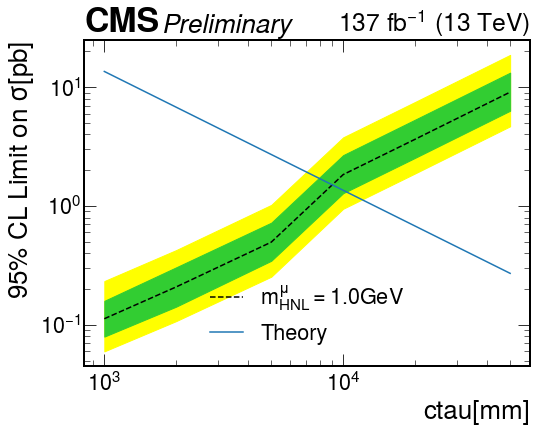

In [21]:
# arr,ctau = loadLimitFiles(1,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(1,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_1 = plotOneMass(arr,ctau,1,r"$m_{HNL}^\mu=1.0GeV$")
ct_xing_1 = intersect(func_1,f_xsec(1),10000)
print(ct_xing_1)
# plt.savefig("./figures/result/AsymLimit_muon_1GeV.pdf")

# V^2 v.s. M limit

In [61]:
ct_xing_3_up

array([ 29.49684106,  21.86318654,  40.39837249, 782.97961663,
        54.79498443])

In [25]:
limits_v9 = np.array([f_v2(1)(ct_xing_1),
                   f_v2(2)(ct_xing_2),
                   f_v2(3)(ct_xing_3),
                   f_v2(3.5)(ct_xing_3p5),
                   f_v2(4)(np.array([ 545.0822784,305.69476147,200.00230833,  95.60042109,79.47867919]))                   
#                     np.array([2.5,3,4,6.5,10])*1e-7                   
                  ])

limits_up_v9 = np.array([
                   f_v2(3)(np.array([ 29.49684106,  21.86318654,  40.39837249, 50,54.79498443])),
                   f_v2(3.5)(ct_xing_3p5_up),
                   f_v2(4)(np.array([ 79.47867919,  95.60042109,200.00230833,305.69476147,545.0822784])),
                  ])

In [24]:
limits/limits_v9

array([[0.95753666, 0.9539409 , 0.95763639, 0.95769334, 0.95893396],
       [0.96209733, 0.95404165, 0.94753579, 0.94234368, 0.94156361],
       [0.94180105, 0.93325059, 0.92288559, 0.91594487, 0.90762085],
       [0.9349954 , 0.91946193, 0.89493297, 0.88643987, 0.79047176],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [26]:
limits_up/limits_up_v9

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.05623786, 1.17621123, 1.05496654, 1.11729962, 1.93698718],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


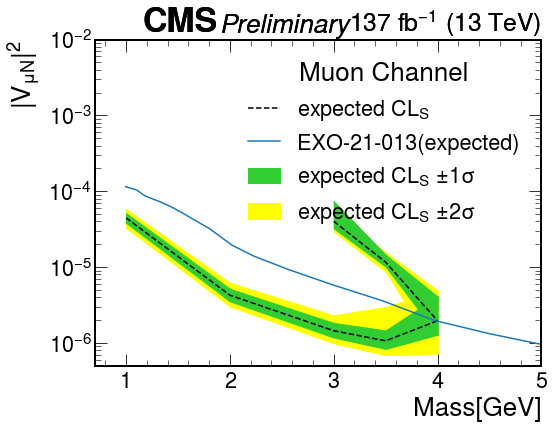

In [13]:
plt.style.use(hep.style.CMS) 

ct_xing_1 = intersect(func_1, f_xsec(1),10000)
ct_xing_2 = intersect(func_2,f_xsec(2),2000)
ct_xing_3 = intersect(func_3,f_xsec(3),[1000,800,700,200,200])
ct_xing_3p5 = intersect(func_3p5,f_xsec(3.5),[1000,800,700,200,200])

EXO = np.genfromtxt("../limit/EXO-21-013_mu_majorana.csv",delimiter=",")

limits = np.array([f_v2(1)(ct_xing_1),
                   f_v2(2)(ct_xing_2),
                   f_v2(3)(ct_xing_3),
                   f_v2(3.5)(ct_xing_3p5),
                   f_v2(4)(np.array([ 545.0822784,305.69476147,200.00230833,  95.60042109,79.47867919]))                   
#                     np.array([2.5,3,4,6.5,10])*1e-7                   
                  ])
masses = [1,2,3,3.5,4]

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
ct_xing_3p5_up = intersect(func_3p5,f_xsec(3.5),[50,50,50,50,50])

limits_up = np.array([
                   f_v2(3)(np.array([ 29.49684106,  21.86318654,  40.39837249, 50,54.79498443])),
                   f_v2(3.5)(ct_xing_3p5_up),
                   f_v2(4)(np.array([ 79.47867919,  95.60042109,200.00230833,305.69476147,545.0822784])),
#                    f_ctau(4.6)(ct_xing_4p6_up),    
#                     np.array([10,6.5,4,3,2.5])*1e-7                      
                  ])
masses_up = [3,3.5,4]
ax = plotlimit(ax,limits_up,masses_up,True,False)

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)")
ax.legend(["Expected","EXO-21-013(expected)",r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"],loc=1)
ax.set_yscale("log")
ax.set_ylabel("$|V_{\mu N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,5)
ax.set_ylim(5e-7,1e-2)
ax.legend(title="Muon Channel")
fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

In [30]:
limits[:,2]

array([4.46646458e-05, 4.26290757e-06, 1.45063763e-06, 1.06795729e-06,
       1.96176358e-06])

(5e-07, 1.0)

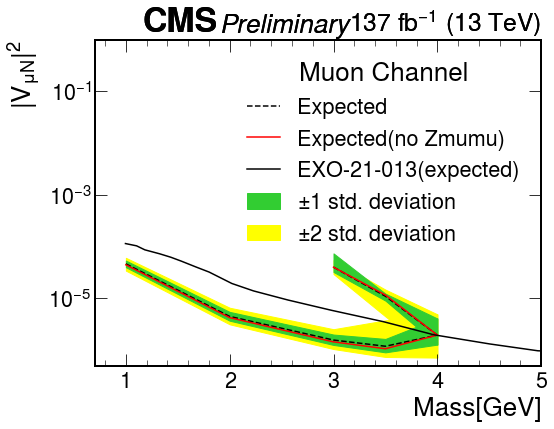

In [53]:
plt.style.use(hep.style.CMS) 



EXO = np.genfromtxt("../limit/EXO-21-013_mu_majorana.csv",delimiter=",")

masses = [1,2,3,3.5,4]

fig, ax = plt.subplots(figsize=(8,6))

ax = plotlimit(ax,limits_v9,masses)

masses_up = [3,3.5,4]
ax = plotlimit(ax,limits_up_v9,masses_up,True,False)

ax.plot(masses,limits[:,2]      ,label="Expected(no Zmumu)",color='r')
ax.plot(masses_up,limits_up[:,2],label='_nolegend_',color='r')

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)",color='black')
ax.legend(["Expected","Expected(no Zmumu)","EXO-21-013(expected)"
           ,r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"],title="Muon Channel",loc=1)
ax.set_yscale("log")
ax.set_ylabel("$|V_{\mu N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,5)
ax.set_ylim(5e-7,1e-0)
# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: Runti

(0.7, 7.0)

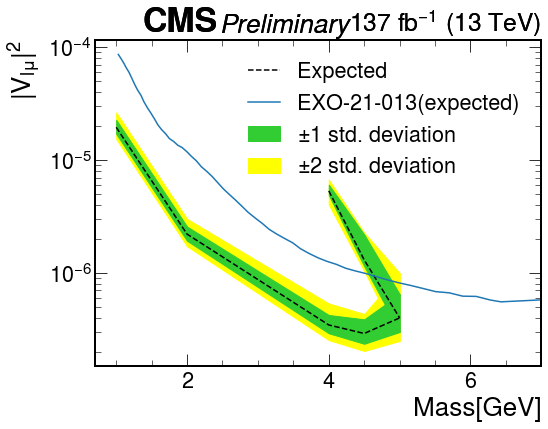

In [94]:
plt.style.use(hep.style.CMS) 

# ct_xing_4 = intersect(funcs, f_xsec(4),1000)
# ct_xing_1 = intersect(funcs_1, f_xsec(1),10000)
# ct_xing_2 = intersect(func_2,f_xsec(2),2000)
# ct_xing_2 = intersect(funcs_2, f_xsec(2),10000)
# ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),[500,600,700,800,1000])
# ct_xing_4p6    = intersect(funcs_4p6, f_xsec(4.6),[500,600,700,800,1000])

# # ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),1000)

# ct_xing_5 = np.array([600,500,400,300,100])

# EXO = np.genfromtxt("../limit/limit.csv",delimiter=",")

# limits = np.array([f_ctau(1)(ct_xing_1),
#                    f_ctau(2)(ct_xing_2),
#                    f_ctau(4)(ct_xing_4),
#                    f_ctau(4.5)(ct_xing_4p5),
# #                    f_ctau(4.6)(ct_xing_4p6),                   
# #                    f_ctau(5)(ct_xing_5),    
#                     np.array([2.5,3,4,6.5,10])*1e-7                   
#                   ])
# masses = [1,2,4,4.5,5]

# fig, ax = plt.subplots(figsize=(8,6))
# ax = plotlimit(ax,limits,masses)

# # ct_xing_4_up = intersect(funcs, f_xsec(4),70)
# ct_xing_4_up = intersect(funcs, f_xsec(4),[70,70,75,70,70])

# # ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),70)
# ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),[90,100,100,140,150])
# ct_xing_4p6_up = intersect(funcs_4p6, f_xsec(4.6),[90,100,91,130,140])

# limits_up = np.array([f_ctau(4)(ct_xing_4_up),
#                    f_ctau(4.5)(ct_xing_4p5_up),
# #                    f_ctau(4.6)(ct_xing_4p6_up),    
#                     np.array([10,6.5,4,3,2.5])*1e-7                      
#                   ])
# masses_up = [4,4.5,5]
# ax = plotlimit(ax,limits_up,masses_up,True,False)

# ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)")
# ax.legend(["Expected","EXO-21-013(expected)",r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"],loc=1)
# ax.set_yscale("log")
# ax.set_ylabel("$|V_{l\mu}|^2$")
# ax.set_xlabel("Mass[GeV]")
# ax.set_xlim(0.7,7)

# # ax.set_ylim(1e-6,1e-5)
# # ax.set_xlim(3.5,5)

# ax.legend()

In [85]:
ct_xing_4_up

array([58.87874915, 65.22626211, 74.0598239 , 80.81095001, 98.0278493 ])

In [89]:
f_ctau_5=np.array([10,6.5,4,3,2.5])*1e-7

In [88]:
f_ctau(4.5)(ct_xing_4p5_up)

array([2.27486421e-06, 2.19244680e-06, 1.30508853e-06, 1.14922354e-06,
       1.04096385e-06])

In [87]:
f_ctau(4.5)(ct_xing_4p5)

array([2.03796464e-07, 2.35981137e-07, 2.91265337e-07, 3.88488367e-07,
       4.33444849e-07])

In [86]:
ct_xing_4p5_up

array([ 95.3903089 ,  98.97617568, 166.2722448 , 188.82314256,
       208.4606492 ])

# 2D limits

In [17]:
def interpolate2D(combineLimits,x,y,nBins=10):
    epsilon = 0.2
    smooth = 1
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = x
        yi = y
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    for i in range(5):
        z = combineLimits[:,i]
        rbfi = Rbf(x,y,z,function='multiquadric', epsilon=epsilon,smooth=smooth)
#         rbfi = Rbf(x,y,function='cubic', epsilon=epsilon,smooth=smooth)
        myXI, myYI = np.meshgrid(xi,yi)
        zi = rbfi(myXI,myYI)
        newLimits.append(zi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, myXI,myYI

In [18]:
x= np.concatenate([np.ones_like(ctau4GeV)*4,2*np.ones_like(ctau2GeV)],axis=0)

In [19]:
y=np.concatenate([ctau4GeV,ctau2GeV],axis=0)

In [22]:
z = np.concatenate([arr4GeV,arr2GeV],axis=0)

In [27]:
z[:,3]

array([ 0.01318735,  0.01260592,  0.02334118,  0.16329081,  0.08882983,
        0.0142238 ,  0.02108977,  0.86800341,  0.0175409 ,  0.0438945 ,
        0.02175238,  0.02693847,  0.03453834, 10.01427176,  0.02558645])

In [59]:
h = hist.Hist("Expected Limit",
         hist.Bin("ct","ctau[mm]",np.logspace(0,np.log(max(y)),len(y)+1)),
         hist.Bin("m",'mass[GeV]',5,0,5)
        )
h.fill(ct = y,m=x, weight=z[:,2])

In [46]:
z[:,2]

array([0.00985002, 0.00941574, 0.01743423, 0.11675269, 0.06369473,
       0.01062418, 0.01565934, 0.6445    , 0.01302427, 0.03259204,
       0.01629602, 0.01862402, 0.02579772, 6.68395508, 0.01883096])

In [50]:
import matplotlib

(1, 10000.0)

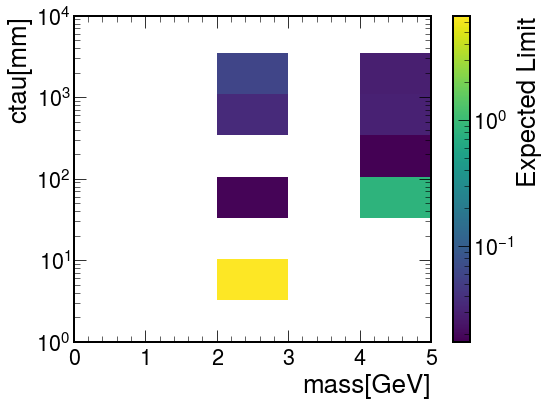

In [60]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

hist.plot2d(h,xaxis="m",ax=ax,patch_opts={"norm":matplotlib.colors.LogNorm()})

ax.set_yscale("log")
ax.set_ylim(1,1e4)

In [272]:
zi, xi,yi = interpolate2D(z,x,y,-1)

In [293]:
z = zi[:,:,3]

In [294]:
z.shape

(15, 15)